In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

In [3]:
# generate underlying causal factors
# which are the durations of the states of comp a-c
min_lenght = 1500
max_length = 2500
length = 500
comp_a_durations = np.random.randint(min_lenght, max_length, length)
comp_b_durations = np.random.randint(min_lenght, max_length, length)
comp_c_durations = np.random.randint(min_lenght, max_length, length)

In [4]:
# generate corresponding signal for causal factor of comp a
comp_a_signal = np.concatenate([[-1]*i if j%2==0 else [1]*i for j,i in enumerate(comp_a_durations)])
comp_b_signal = np.concatenate([[-1]*i if j%2==0 else [1]*i for j,i in enumerate(comp_b_durations)])
# comp_c_signal = np.concatenate([[-1]*i if j%2==0 else [1]*i for j,i in enumerate(comp_c_durations)])

In [5]:
# get list of gain values for dynamic system simulation
def get_comp_signal(comp_duration):
    comp_kp_ls = [-1]
    for i in range(1, len(comp_duration)):
        comp_kp_ls.append(-1 if comp_kp_ls[i-1] == 1 else 1)
    return np.array(comp_kp_ls)
        
comp_a_kp_ls = get_comp_signal(comp_b_durations)


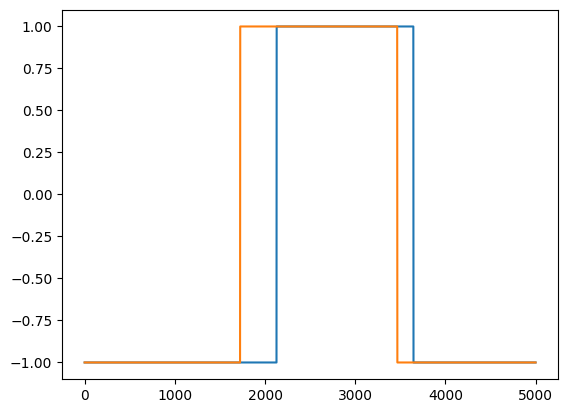

In [6]:
plt.plot(comp_a_signal[0:5000])
plt.plot(comp_b_signal[0:5000])

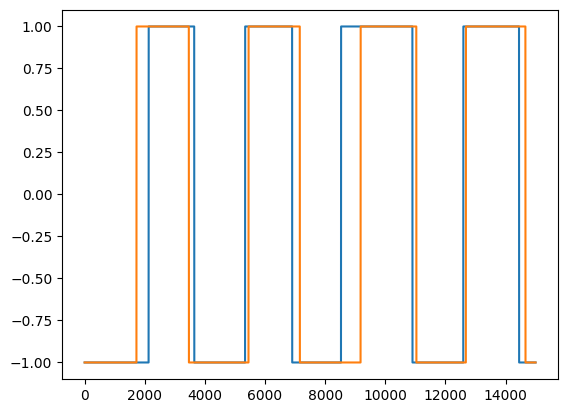

In [7]:
plt.plot(comp_a_signal[0:15000])
plt.plot(comp_b_signal[0:15000])

# Component A Signals

In [8]:
# tau * dy2/dt2 + 2*zeta*tau*dy/dt + y = Kp*u
tau = 20.0   # time constant
zeta = 0.3 # damping factor
theta = 100.0 # no time delay
du = 1.0    # change in u
taup = 50

# (3) ODE Integrator
def second_order_model(x,t, Kp):
    y = x[0]
    dydt = x[1]
    dy2dt2 = (-2.0*zeta*tau*dydt - y + Kp*du)/tau**2
    return [dydt,dy2dt2]

def first_order_model(y,t,Kp):
    u = 1
    return (-y + Kp * u)/taup

In [9]:
x0_2nd = [-1, 0]
x0_1st = [-1.1, 0]
y_2nd_ls = []
y_1st_ls = []

for Kp, tmax in zip(comp_a_kp_ls, comp_a_durations):
    t = np.linspace(0, tmax, tmax)
    x_2nd = odeint(second_order_model, x0_2nd, t, (Kp,))
    y_2nd = x_2nd[:, 0]
    y_2nd_ls.append(y_2nd)
    x0_2nd = list(x_2nd[-1, :])
    
    x_1st = odeint(first_order_model, x0_1st, t, (Kp-.1,))
    y_1st = x_1st[:, 0]
    y_1st_ls.append(y_1st)
    x0_1st = list(x_1st[-1, :])

In [10]:
sig_a1 = comp_a_signal
sig_a2 = np.concatenate(y_2nd_ls)
sig_a3 = np.concatenate(y_1st_ls)

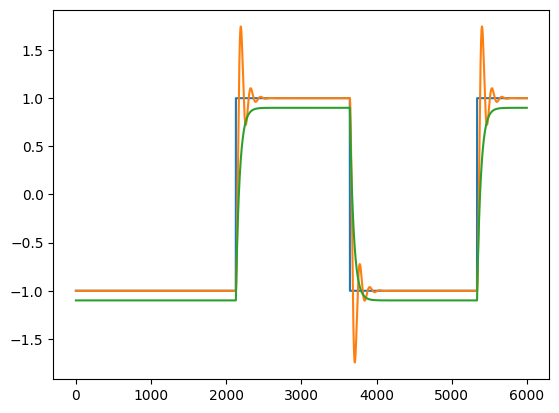

In [11]:
plt.figure(1)
plt.plot(sig_a1[0:6000])
plt.plot(sig_a2[0:6000])
plt.plot(sig_a3[0:6000])

# Component B Signals

In [12]:
min_len = min([len(sig) for sig in [comp_a_signal, comp_b_signal]])
min_len

994295

In [13]:
df = pd.DataFrame(dict(comp_a=comp_a_signal[:min_len], comp_b=comp_b_signal[:min_len]))

In [14]:
t = np.linspace(0, min_len, min_len)
# sig_4 = (comp_b_signal+1) * np.sin(2*np.pi*1/500*t)
sig_b1 = comp_b_signal
sig_b2 = df.comp_b.cumsum()/df.comp_b.cumsum().max()
sig_b3 = sig_b2 + .5*np.sin(2*np.pi * 1/1000 * t)

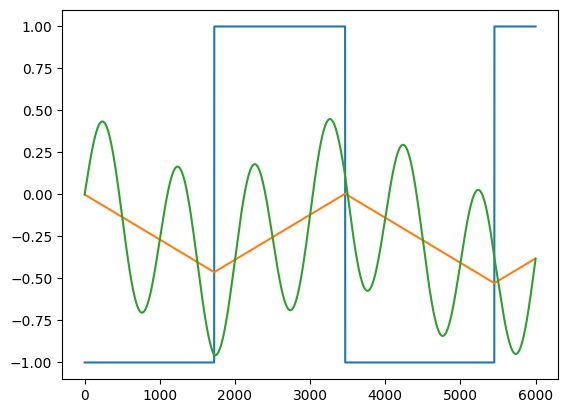

In [15]:
plt.plot(sig_b1[0:6000])
plt.plot(sig_b2[0:6000])
plt.plot(sig_b3[0:6000])

# Modify sigs for cross influence

In [16]:
sig_a1 = sig_a1[:min_len] + .5*sig_b2[:min_len]
sig_b1 = sig_b1[:min_len] + .1*sig_a1[:min_len]

In [17]:
df.head()

,comp_a,comp_b
0,-1,-1
1,-1,-1
2,-1,-1
3,-1,-1
4,-1,-1


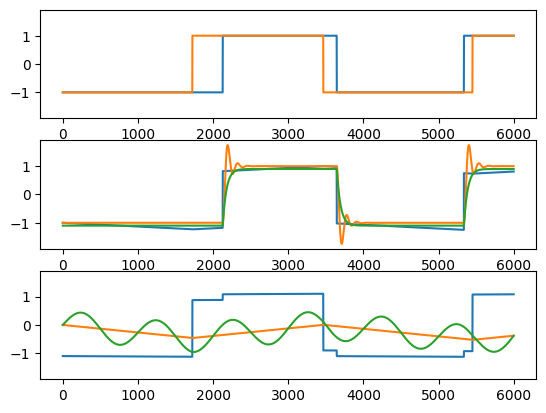

In [18]:
start_idx=0
end_idx=6000
fig, axs = plt.subplots(3, 1, sharey='all')
axs[0].plot(df[start_idx:end_idx])
axs[1].plot(sig_a1[start_idx:end_idx])
axs[1].plot(sig_a2[start_idx:end_idx])
axs[1].plot(sig_a3[start_idx:end_idx])
axs[2].plot(sig_b1[start_idx:end_idx])
axs[2].plot(sig_b2[start_idx:end_idx])
axs[2].plot(sig_b3[start_idx:end_idx])
# axs[1, 0].plot(sample_x_hat[index, :, :].detach().numpy().T)
# axs[0, 1].plot(sample_y[index, :, :].detach().numpy().T)
# axs[1, 1].plot(sample_y_hat[index, :, :].detach().numpy().T)
fig.show()

In [19]:
import pandas as pd
df = pd.DataFrame(dict(sig_a1=sig_a1[:min_len],
                       sig_a2=sig_a2[:min_len],
                       sig_a3=sig_a3[:min_len],
                       sig_b1=sig_b1[:min_len],
                       sig_b2=sig_b2[:min_len],
                       sig_b3=sig_b3[:min_len],
                      ))
TRAIN_DATA_PATH = 'data/simulated_data.csv'
# df.to_csv(TRAIN_DATA_PATH, index=False)

In [20]:
os.chdir('./pipeline/src/')

In [21]:
from data_module_sim import SimDataSet

In [22]:
df.head()

,sig_a1,sig_a2,sig_a3,sig_b1,sig_b2,sig_b3
0,-1.000134,-1.0,-1.1,-1.100013,-0.000268,-0.000268
1,-1.000268,-1.0,-1.1,-1.100027,-0.000537,0.002605
2,-1.000403,-1.0,-1.1,-1.100040,-0.000805,0.005478
3,-1.000537,-1.0,-1.1,-1.100054,-0.001074,0.008350
4,-1.000671,-1.0,-1.1,-1.100067,-0.001342,0.011223


In [23]:
subsystems_map = {'a': ['sig_a1', 'sig_a2', 'sig_a3'],
                  'b': ['sig_b1', 'sig_b2', 'sig_b3']}
input_cols = ['sig_a1', 'sig_a2', 'sig_a3', 'sig_b1', 'sig_b2', 'sig_b3']

In [24]:
ds = SimDataSet(dataframe=df,
           subsystems_map=subsystems_map,
           input_cols=input_cols,
           number_of_samples=100,
          seq_len=500)

In [25]:
ds[0][0].shape

(6, 500)

In [26]:
from data_module_sim import SIMDataModule

In [33]:
dm = SIMDataModule(df_train=df,
                   df_val=df,
           subsystems_map=subsystems_map,
           input_cols=input_cols,
           number_of_train_samples=100,
                   number_of_val_samples=10,
          seq_len=480,
                  batch_size=10)

In [34]:
dl_train = dm.train_dataloader()

In [35]:
next(iter(dl_train))[0].shape

torch.Size([10, 6, 480])

In [36]:
from run_diag_tcn_training import run_training

In [38]:
run_training(
    data_modeule=dm,
    batch_size=32,
    num_workers=20,
    subsystems_map=subsystems_map,
    input_cols=input_cols,
    model_output_path='/home/jovyan/diag-tcn-vae/tmp_sim_model',
    kernel_size=15,
    max_epochs=2,
    learning_rate=1e-3,
    logs_path='/home/jovyan/diag-tcn-vae/logs/',
    early_stopping_patience=10,
    latent_dim=5,
    dropout=0,
    model_name='sim-diag-tcn-vae'
)

TypeError: run_training() got an unexpected keyword argument 'model_name'